In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import emcee
import corner
from scipy.optimize import minimize

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928

In [4]:
lc_df = pd.read_hdf('../data/P48/SN2019yvq/data/photometry/P48/forcephot_product/lightcurves/ZTF19adcecwu_force_phot_nob.h5')
lc_df.head()

,jdobs,filter,seeing,gain,zp,ezp,programid,fieldid,ccdid,qid,...,Fmcmc,Fmcmc_unc,Fmcmc_low_3sigma,Fmcmc_low_2sigma,Fmcmc_low_1sigma,Fmcmc_high_3sigma,Fmcmc_high_2sigma,Fmcmc_high_1sigma,Fratio,Fratio_unc
0,2.458096e+06,b'r',2.991,7.412960,26.0,0.000014,0.0,820.0,16.0,4.0,...,-92.749269,52.049746,-248.620568,-196.183913,-144.528417,63.577329,11.779072,-40.428925,-3.692415e-09,2.072138e-09
1,2.458102e+06,b'r',2.052,7.284357,26.0,0.000011,0.0,820.0,16.0,99.0,...,-8.451378,75.078089,-239.581765,-159.997857,-83.663750,217.076468,142.444704,66.492428,-3.364554e-10,2.988913e-09
2,2.458102e+06,b'r',3.033,7.331480,26.0,0.000012,0.0,820.0,16.0,99.0,...,-55.895978,70.641599,-267.197469,-197.228337,-126.396827,156.870432,85.556411,14.886371,-2.225259e-09,2.812293e-09
3,2.458102e+06,b'r',4.261,7.284363,26.0,0.000018,0.0,820.0,16.0,99.0,...,62.241375,71.282396,-152.188193,-80.921047,-9.137663,276.776605,204.683283,133.427129,2.477874e-09,2.837803e-09
4,2.458104e+06,b'r',2.086,0.985353,26.0,0.000409,0.0,820.0,16.0,99.0,...,358.088022,272.903154,-461.784911,-188.963154,84.078825,1180.937793,899.150532,629.885134,1.425574e-08,1.086447e-08


In [5]:
SNT=5
Fratio = lc_df["Fratio"].values
Fratio_unc = lc_df["Fratio_unc"].values
ix = Fratio > SNT*Fratio_unc


mags = -2.5 * np.log10(Fratio[ix])
emags = 2.5 / np.log(10) * Fratio_unc[ix] / Fratio[ix]
filt_id = lc_df.filterid.values

ulims = -2.5*np.log10(5*Fratio_unc[~ix])

### Fit g-band light curve around peak

In [6]:
t_rf = (lc_df.jdobs.iloc[ix].values - 2400000.5 - tb_max)/(1+z)

g_peak = np.where((t_rf > -5) & 
                  (t_rf < 20) & 
                  (filt_id[ix] == 1))

In [7]:
def lnlike(theta, t, m, m_unc):
    
    p0, p1, p2, p3 = theta
    
    model = p0 + p1*t + p2*t**2 + p3*t**3
    
    lnl = -0.5*np.sum((m - model)**2/m_unc**2)
    
    return lnl

def neg_lnlike(theta, t, m, m_unc):
    return -1*lnlike(theta, t, m, m_unc)

In [8]:
ml_res = minimize(neg_lnlike, (15, -0.05,0.01, 0.001), method='Powell', # Powell method does not need derivatives
                      args=(t_rf[g_peak], mags[g_peak], emags[g_peak]))
ml_res

   direc: array([[-8.01233722e-03, -7.75987092e-04,  1.84923615e-04,
        -3.92762980e-06],
       [ 3.15737776e-01,  5.28456824e-02, -2.98850064e-03,
        -1.82387480e-05],
       [-2.05456385e-01,  1.32263646e-01, -2.89782970e-03,
        -3.02634570e-04],
       [ 8.96066981e-05,  3.77657416e-05, -8.60055885e-06,
         3.66882892e-07]])
     fun: 82.63118145646297
 message: 'Optimization terminated successfully.'
    nfev: 643
     nit: 12
  status: 0
 success: True
       x: array([ 1.48239562e+01, -1.10100753e-03,  9.01388628e-03, -2.18817719e-04])

In [9]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(t_rf[g_peak], 
                                      mags[g_peak], 
                                      emags[g_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print('tau = {}'.format(tau))
        break
    old_tau = tau

 14%|█▍        | 14000/100000 [00:12<01:14, 1151.40it/s]

tau = [42.5685507  47.61377958 45.98617227 45.22918068]


<IPython.core.display.Javascript object>


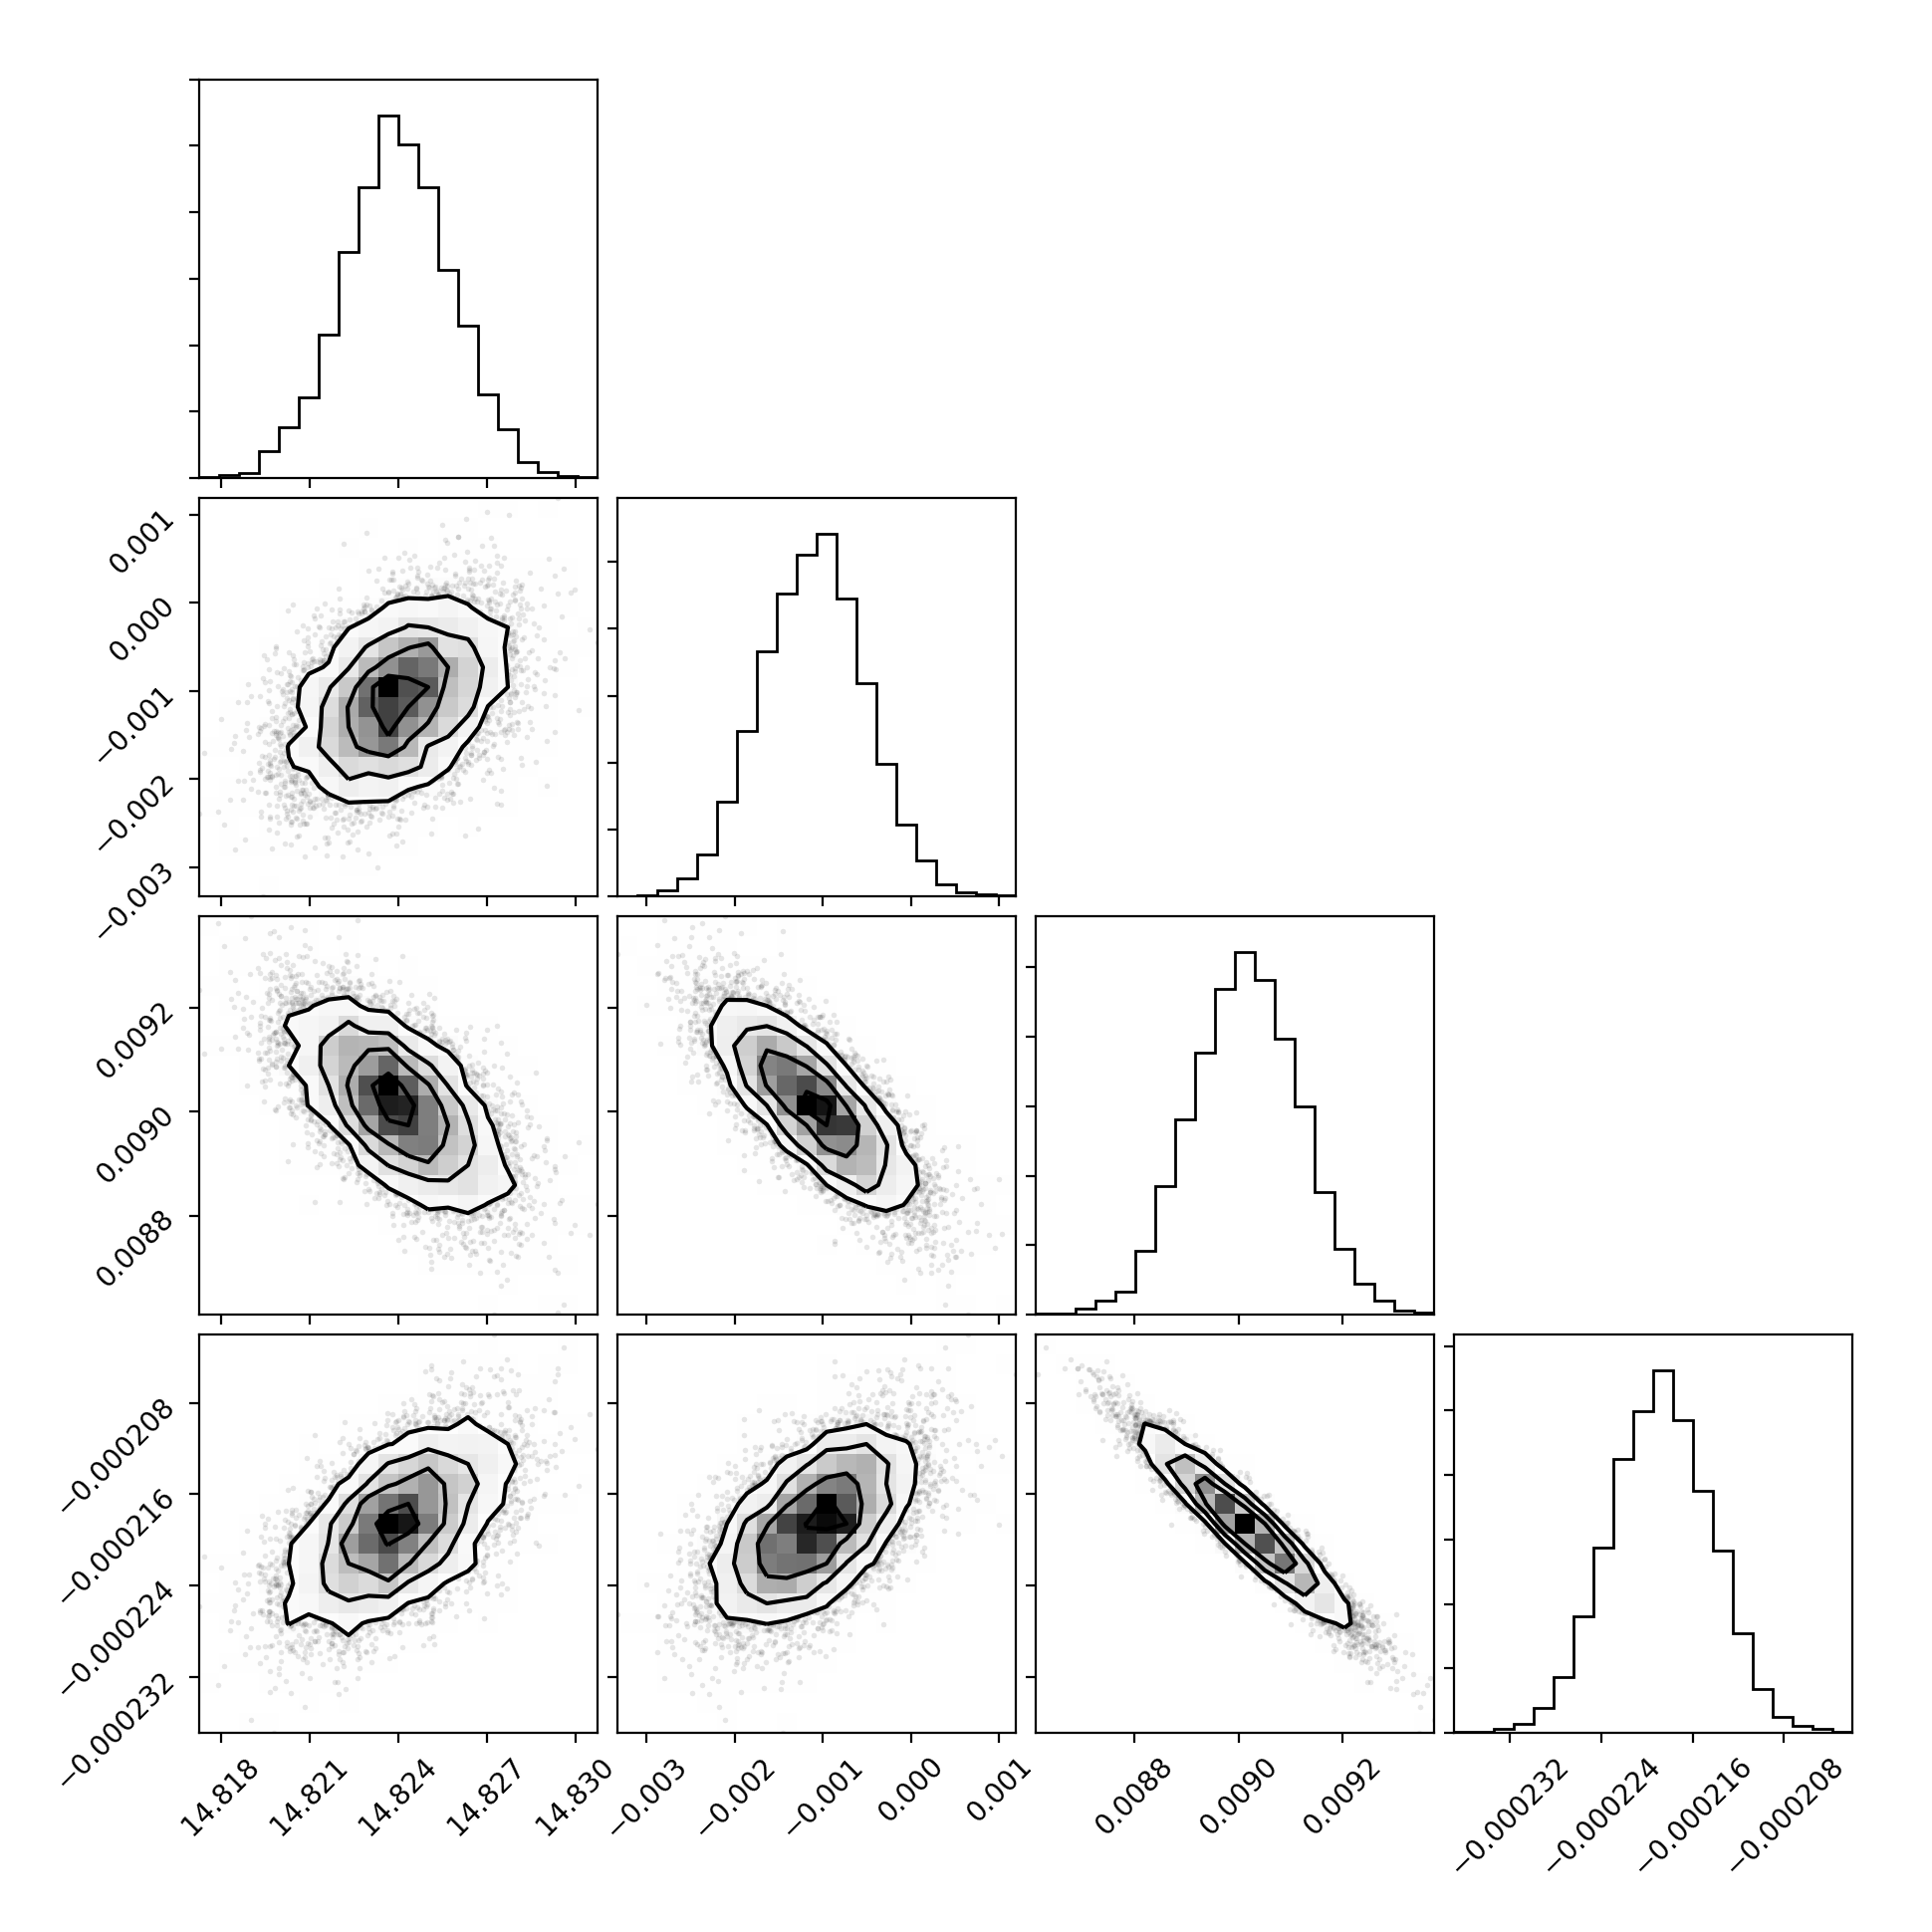

In [11]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


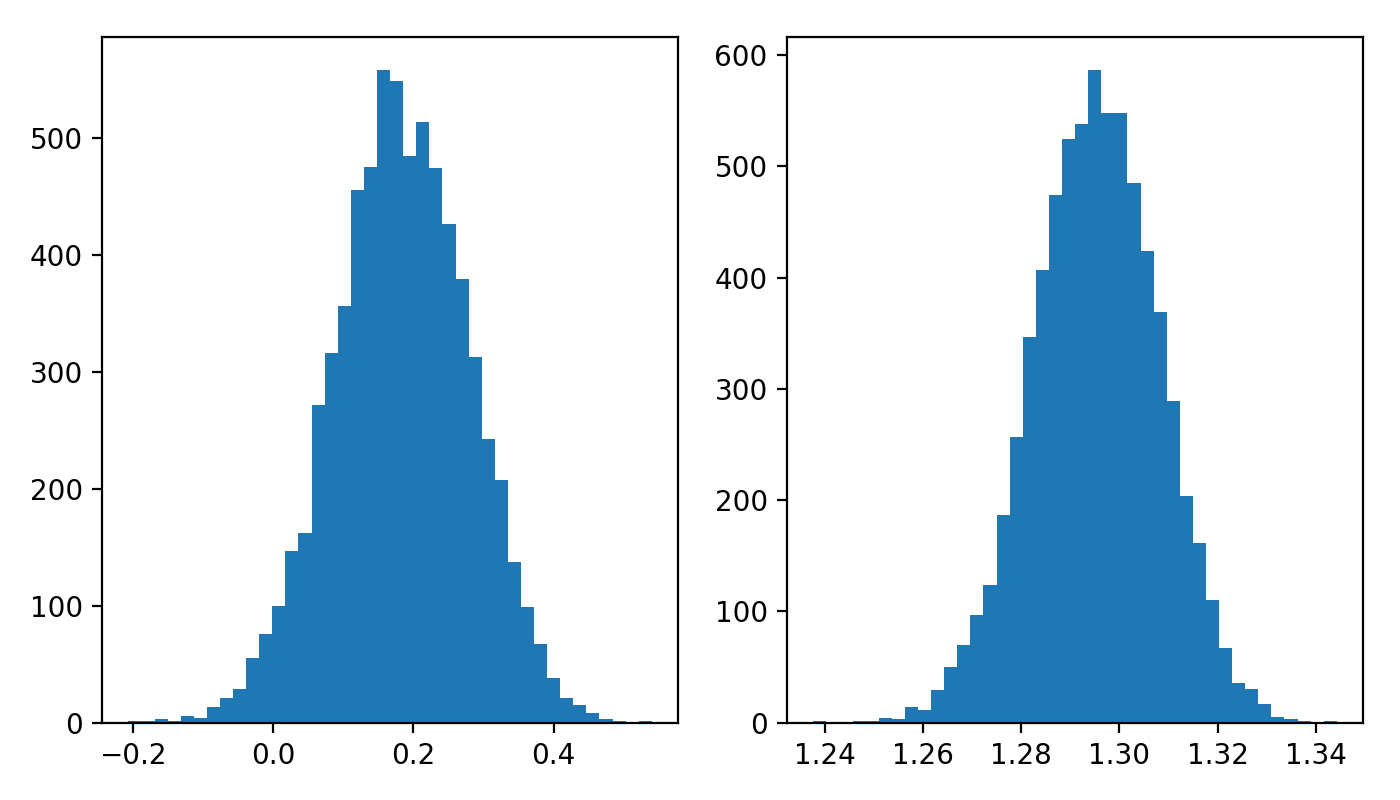

68% CR on t_peak is: [0.08687822 0.18197111 0.28062195]
68% CR on dm_15 is: [1.28225211 1.29529405 1.3081324 ]


In [12]:
# derivative gives quadratic
# (-b +/- sqrt(b**2 - 4*a*c))/2a

t_peak = (-2*samples[:,2] + np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])

dm_15 = np.zeros_like(t_peak)
for samp_num, (p, t) in enumerate(zip(samples, t_peak)):
    dm_15[samp_num] = np.polyval(p[::-1], t+15) - np.polyval(p[::-1], t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
ax1.hist(t_peak, bins=40)
ax2.hist(dm_15, bins=40)
fig.tight_layout()

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135))))
print('68% CR on dm_15 is: {}'.format(np.percentile(dm_15, (15.865,50,84.135))))

<IPython.core.display.Javascript object>


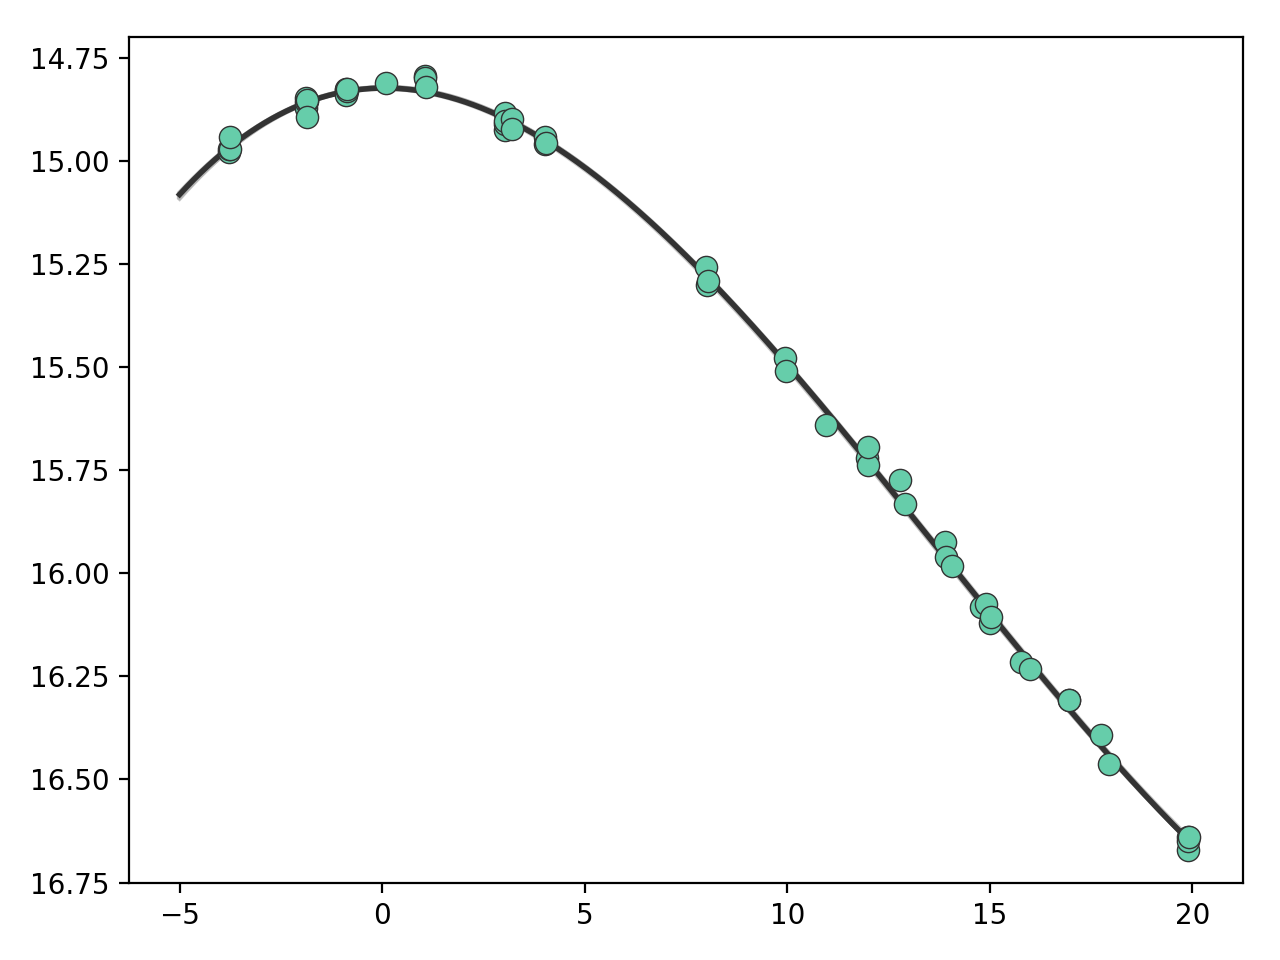

In [13]:
plt.figure()
plt.errorbar(t_rf[g_peak], mags[g_peak], emags[g_peak], 
             fmt='o', color='MediumAquaMarine', 
             mec='0.2', mew=0.5, ms=8)

t_grid = np.linspace(-5, 20,1000)


max_post = samples[np.argmax(sampler.get_log_prob(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int)))]
for samp_num in np.random.choice(len(samples), 10, replace=False):
    plt.plot(t_grid, 
             np.polyval(samples[samp_num,::-1], t_grid),
             '0.7', alpha=0.7)
plt.plot(t_grid, 
         np.polyval(max_post[::-1], t_grid),
         '0.2', lw=2)
    
plt.ylim(16.75,14.7)
plt.tight_layout()

### Fit r-band light curve around peak

In [14]:
r_peak = np.where((t_rf > -5) & 
                  (t_rf < 20) & 
                  (filt_id[ix] == 2))

In [15]:
ml_res = minimize(neg_lnlike, (15, -0.05,0.01, 0.001), method='Powell', # Powell method does not need derivatives
                      args=(t_rf[r_peak], mags[r_peak], emags[r_peak]))
ml_res

   direc: array([[-9.18939493e-02,  2.56435421e-01, -1.06522243e-02,
        -3.78127567e-04],
       [ 6.48718683e-01, -2.32520625e-02, -7.66670916e-04,
        -3.13178777e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.01005720e-01, -5.56751662e-02,  1.27094432e-02,
        -5.50952221e-04]])
     fun: 110.46523914390218
 message: 'Optimization terminated successfully.'
    nfev: 341
     nit: 7
  status: 0
 success: True
       x: array([ 1.46564328e+01, -1.71064157e-02,  5.91477925e-03, -1.59151508e-04])

In [16]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos

In [17]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(t_rf[r_peak], 
                                      mags[r_peak], 
                                      emags[r_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print('tau = {}'.format(tau))
        break
    old_tau = tau

 20%|██        | 20000/100000 [00:18<01:12, 1104.98it/s]

tau = [46.74809657 51.74724547 50.79910209 49.67553139]


<IPython.core.display.Javascript object>


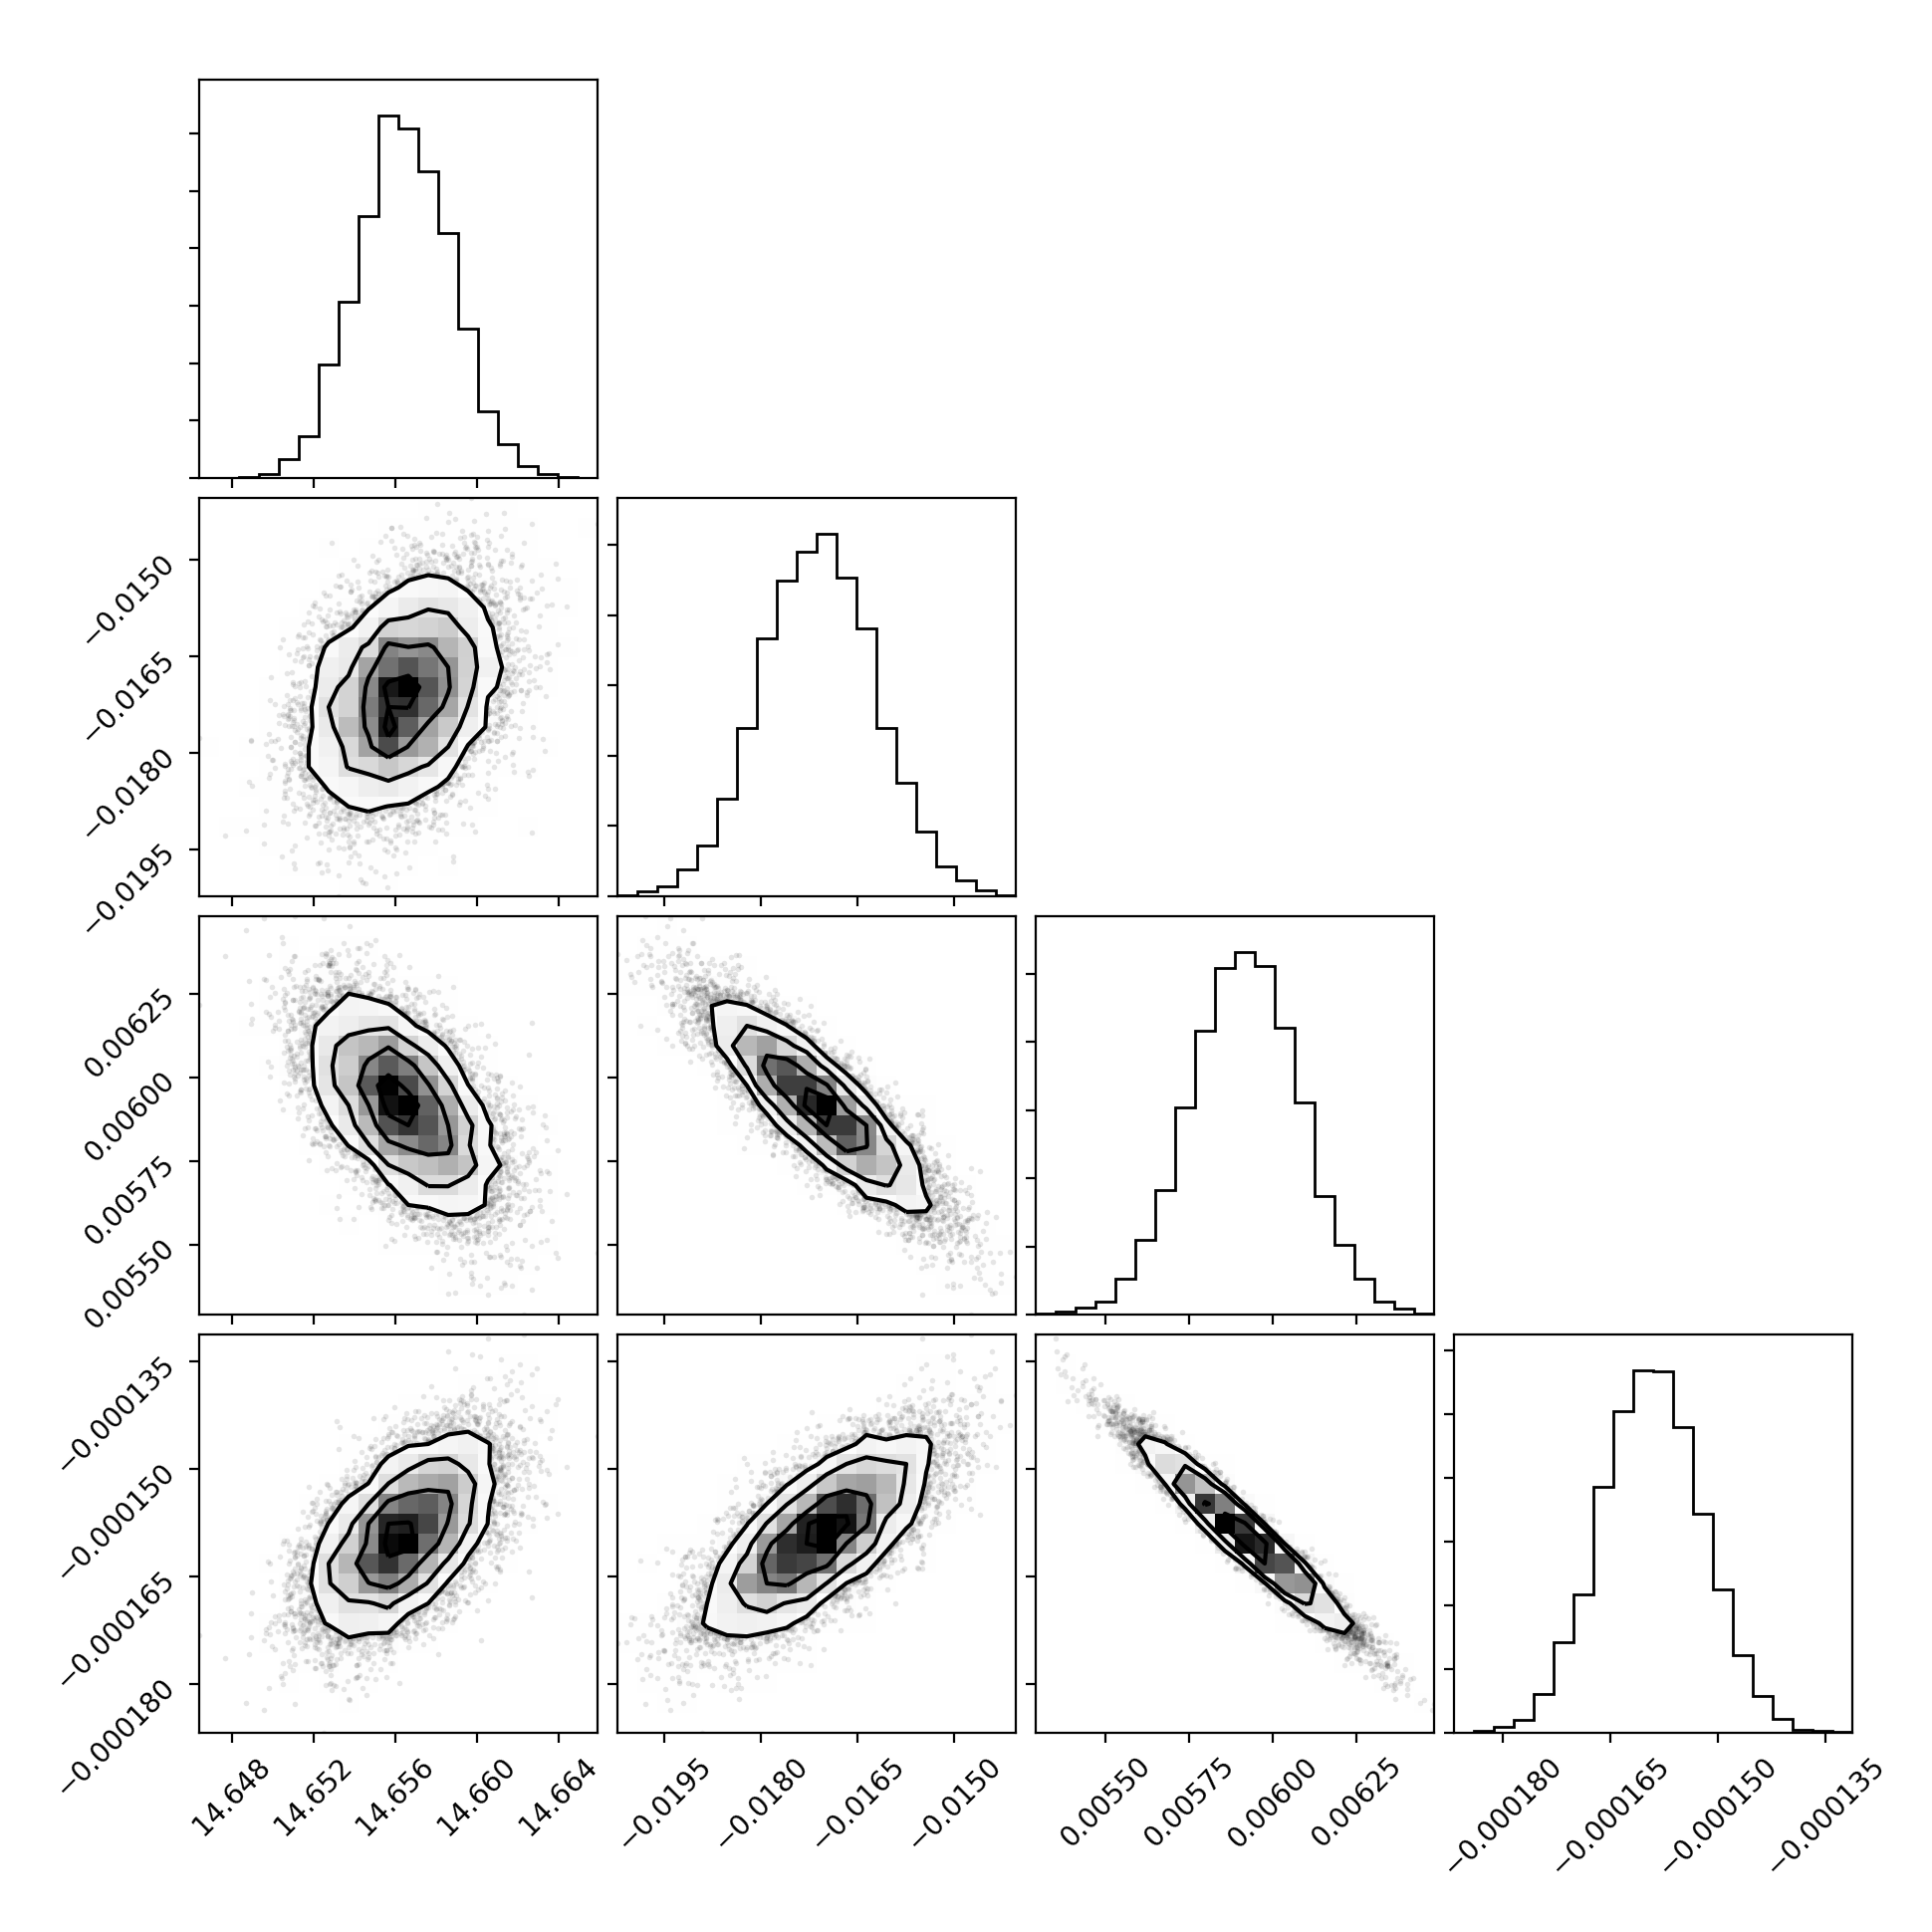

In [18]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


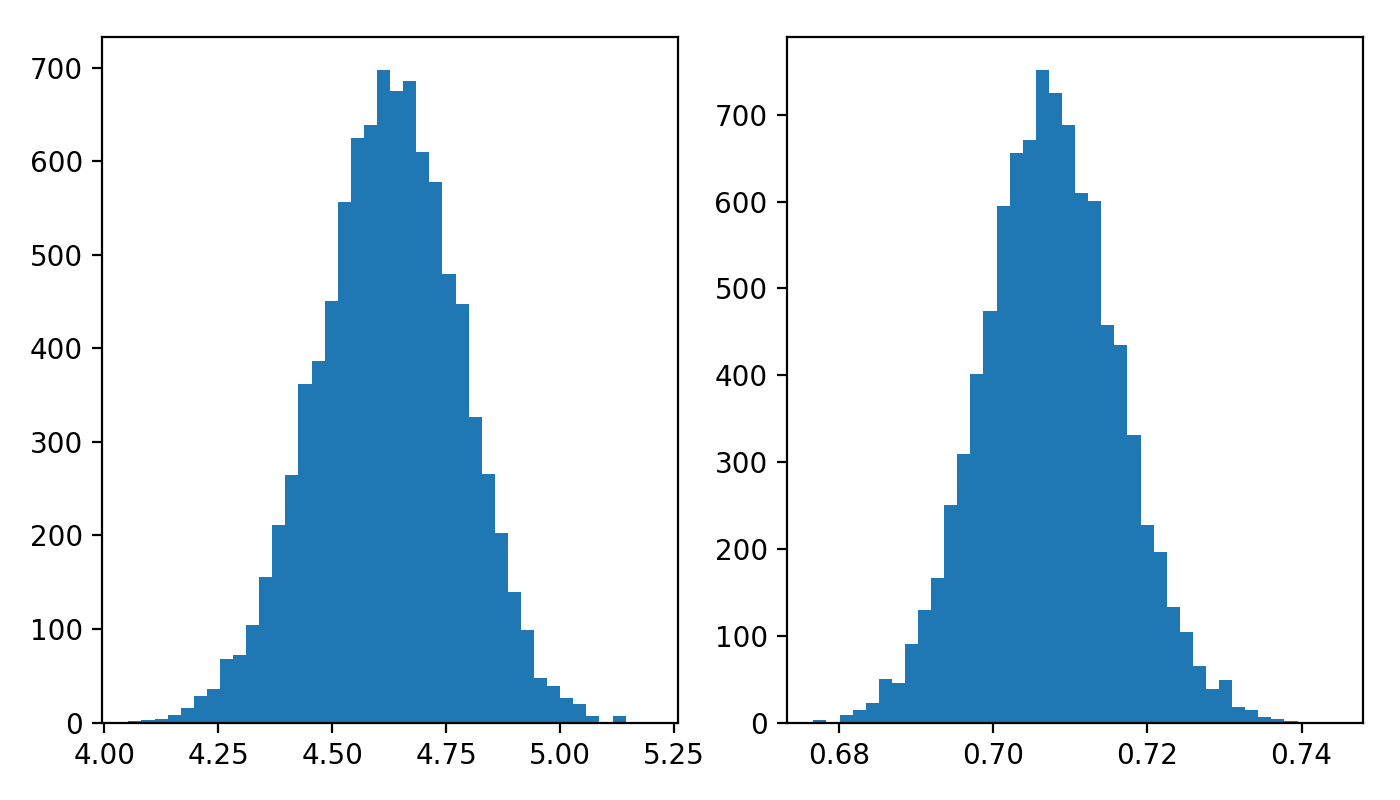

68% CR on t_peak is: [4.46553734 4.62632978 4.77972636]
68% CR on dm_15 is: [0.69873025 0.70731939 0.71629239]


In [19]:
# derivative gives quadratic
# (-b +/- sqrt(b**2 - 4*a*c))/2a

t_peak = (-2*samples[:,2] + np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])

dm_15 = np.zeros_like(t_peak)
for samp_num, (p, t) in enumerate(zip(samples, t_peak)):
    dm_15[samp_num] = np.polyval(p[::-1], t+15) - np.polyval(p[::-1], t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
ax1.hist(t_peak, bins=40)
ax2.hist(dm_15, bins=40)
fig.tight_layout()

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135))))
print('68% CR on dm_15 is: {}'.format(np.percentile(dm_15, (15.865,50,84.135))))

<IPython.core.display.Javascript object>


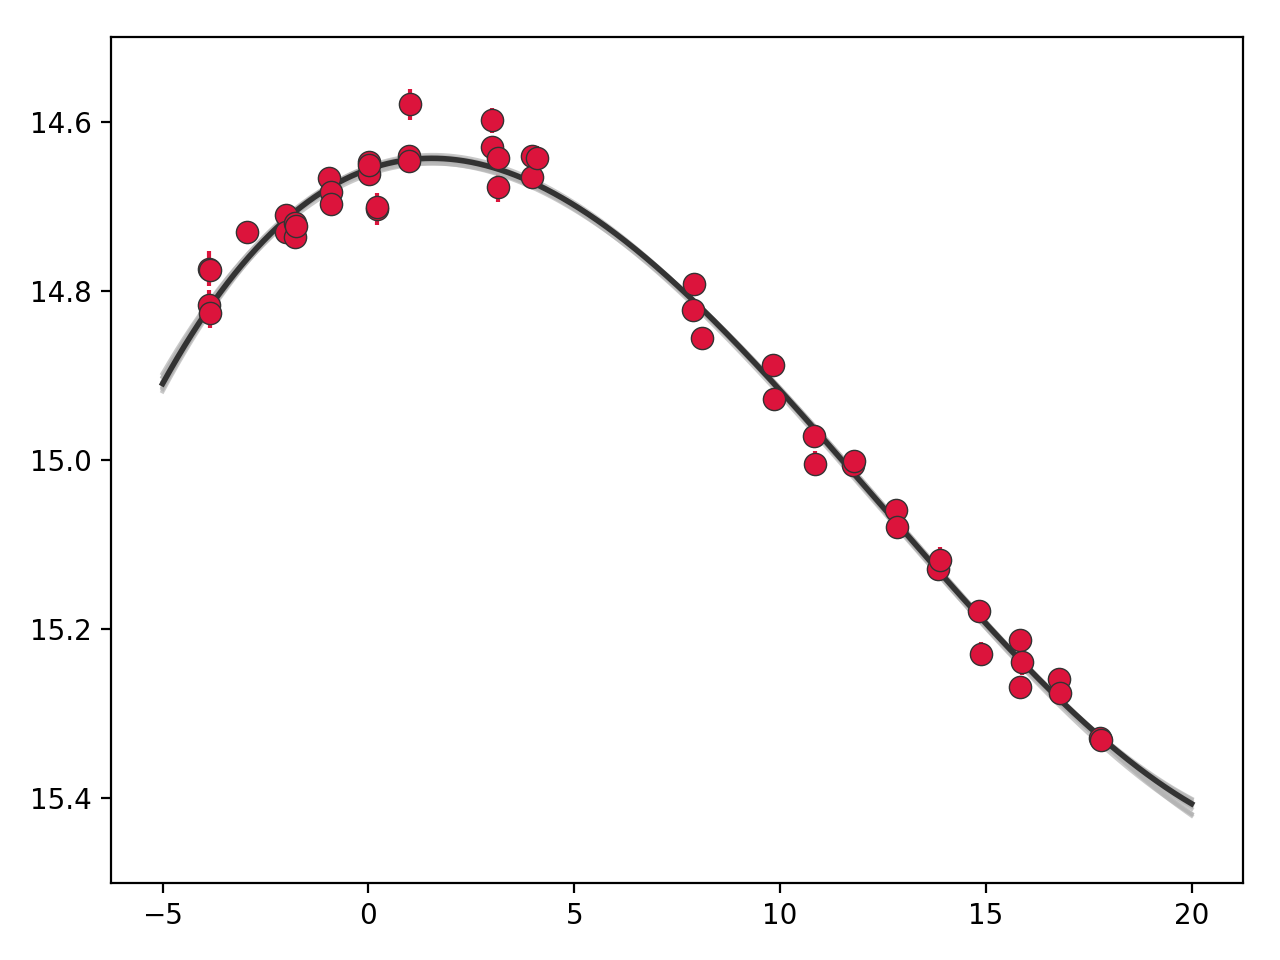

In [20]:
plt.figure()
plt.errorbar(t_rf[r_peak], mags[r_peak], emags[r_peak], 
             fmt='o', color='Crimson', 
             mec='0.2', mew=0.5, ms=8)


t_grid = np.linspace(-5, 20,1000)


max_post = samples[np.argmax(sampler.get_log_prob(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int)))]
for samp_num in np.random.choice(len(samples), 10, replace=False):
    plt.plot(t_grid, 
             np.polyval(samples[samp_num,::-1], t_grid),
             '0.7', alpha=0.7)
plt.plot(t_grid, 
         np.polyval(max_post[::-1], t_grid),
         '0.2', lw=2)
    
plt.ylim(15.5,14.5)
plt.tight_layout()

### Fit i-band light curve around peak

In [21]:
i_peak = np.where((t_rf > -5) & 
                  (t_rf < 20) & 
                  (filt_id[ix] == 3))

In [22]:
ml_res = minimize(neg_lnlike, (15, -0.05,0.01, 0.001), method='Powell', # Powell method does not need derivatives
                      args=(t_rf[i_peak], mags[i_peak], emags[i_peak]))
ml_res

   direc: array([[-7.78155810e-01,  3.51114716e-01, -1.10626746e-02,
        -3.91222828e-04],
       [ 2.15326251e+00, -7.48109193e-02, -1.81905013e-03,
        -6.69451032e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-6.73462696e-02, -7.06328256e-02,  1.26838445e-02,
        -4.75104528e-04]])
     fun: 77.18740507333474
 message: 'Optimization terminated successfully.'
    nfev: 325
     nit: 7
  status: 0
 success: True
       x: array([ 1.51271518e+01, -8.93895955e-03,  4.03408621e-03, -1.22838340e-04])

In [23]:
ml_guess = ml_res.x
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim

nwalkers = 25

#initial position of walkers
rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
pos = ml_guess*rand_pos

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(t_rf[i_peak], 
                                      mags[i_peak], 
                                      emags[i_peak]))


max_samples = 100000

old_tau = np.inf
for sample in sampler.sample(pos, 
                             iterations=max_samples, 
                             progress=True):
    if sampler.iteration % int(2e3):
        continue
    

    tau = sampler.get_autocorr_time(tol=0)

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print('tau = {}'.format(tau))
        break
    old_tau = tau

 32%|███▏      | 32000/100000 [00:29<01:02, 1093.23it/s]

tau = [48.34285188 51.38083783 51.54723732 51.8801224 ]


<IPython.core.display.Javascript object>


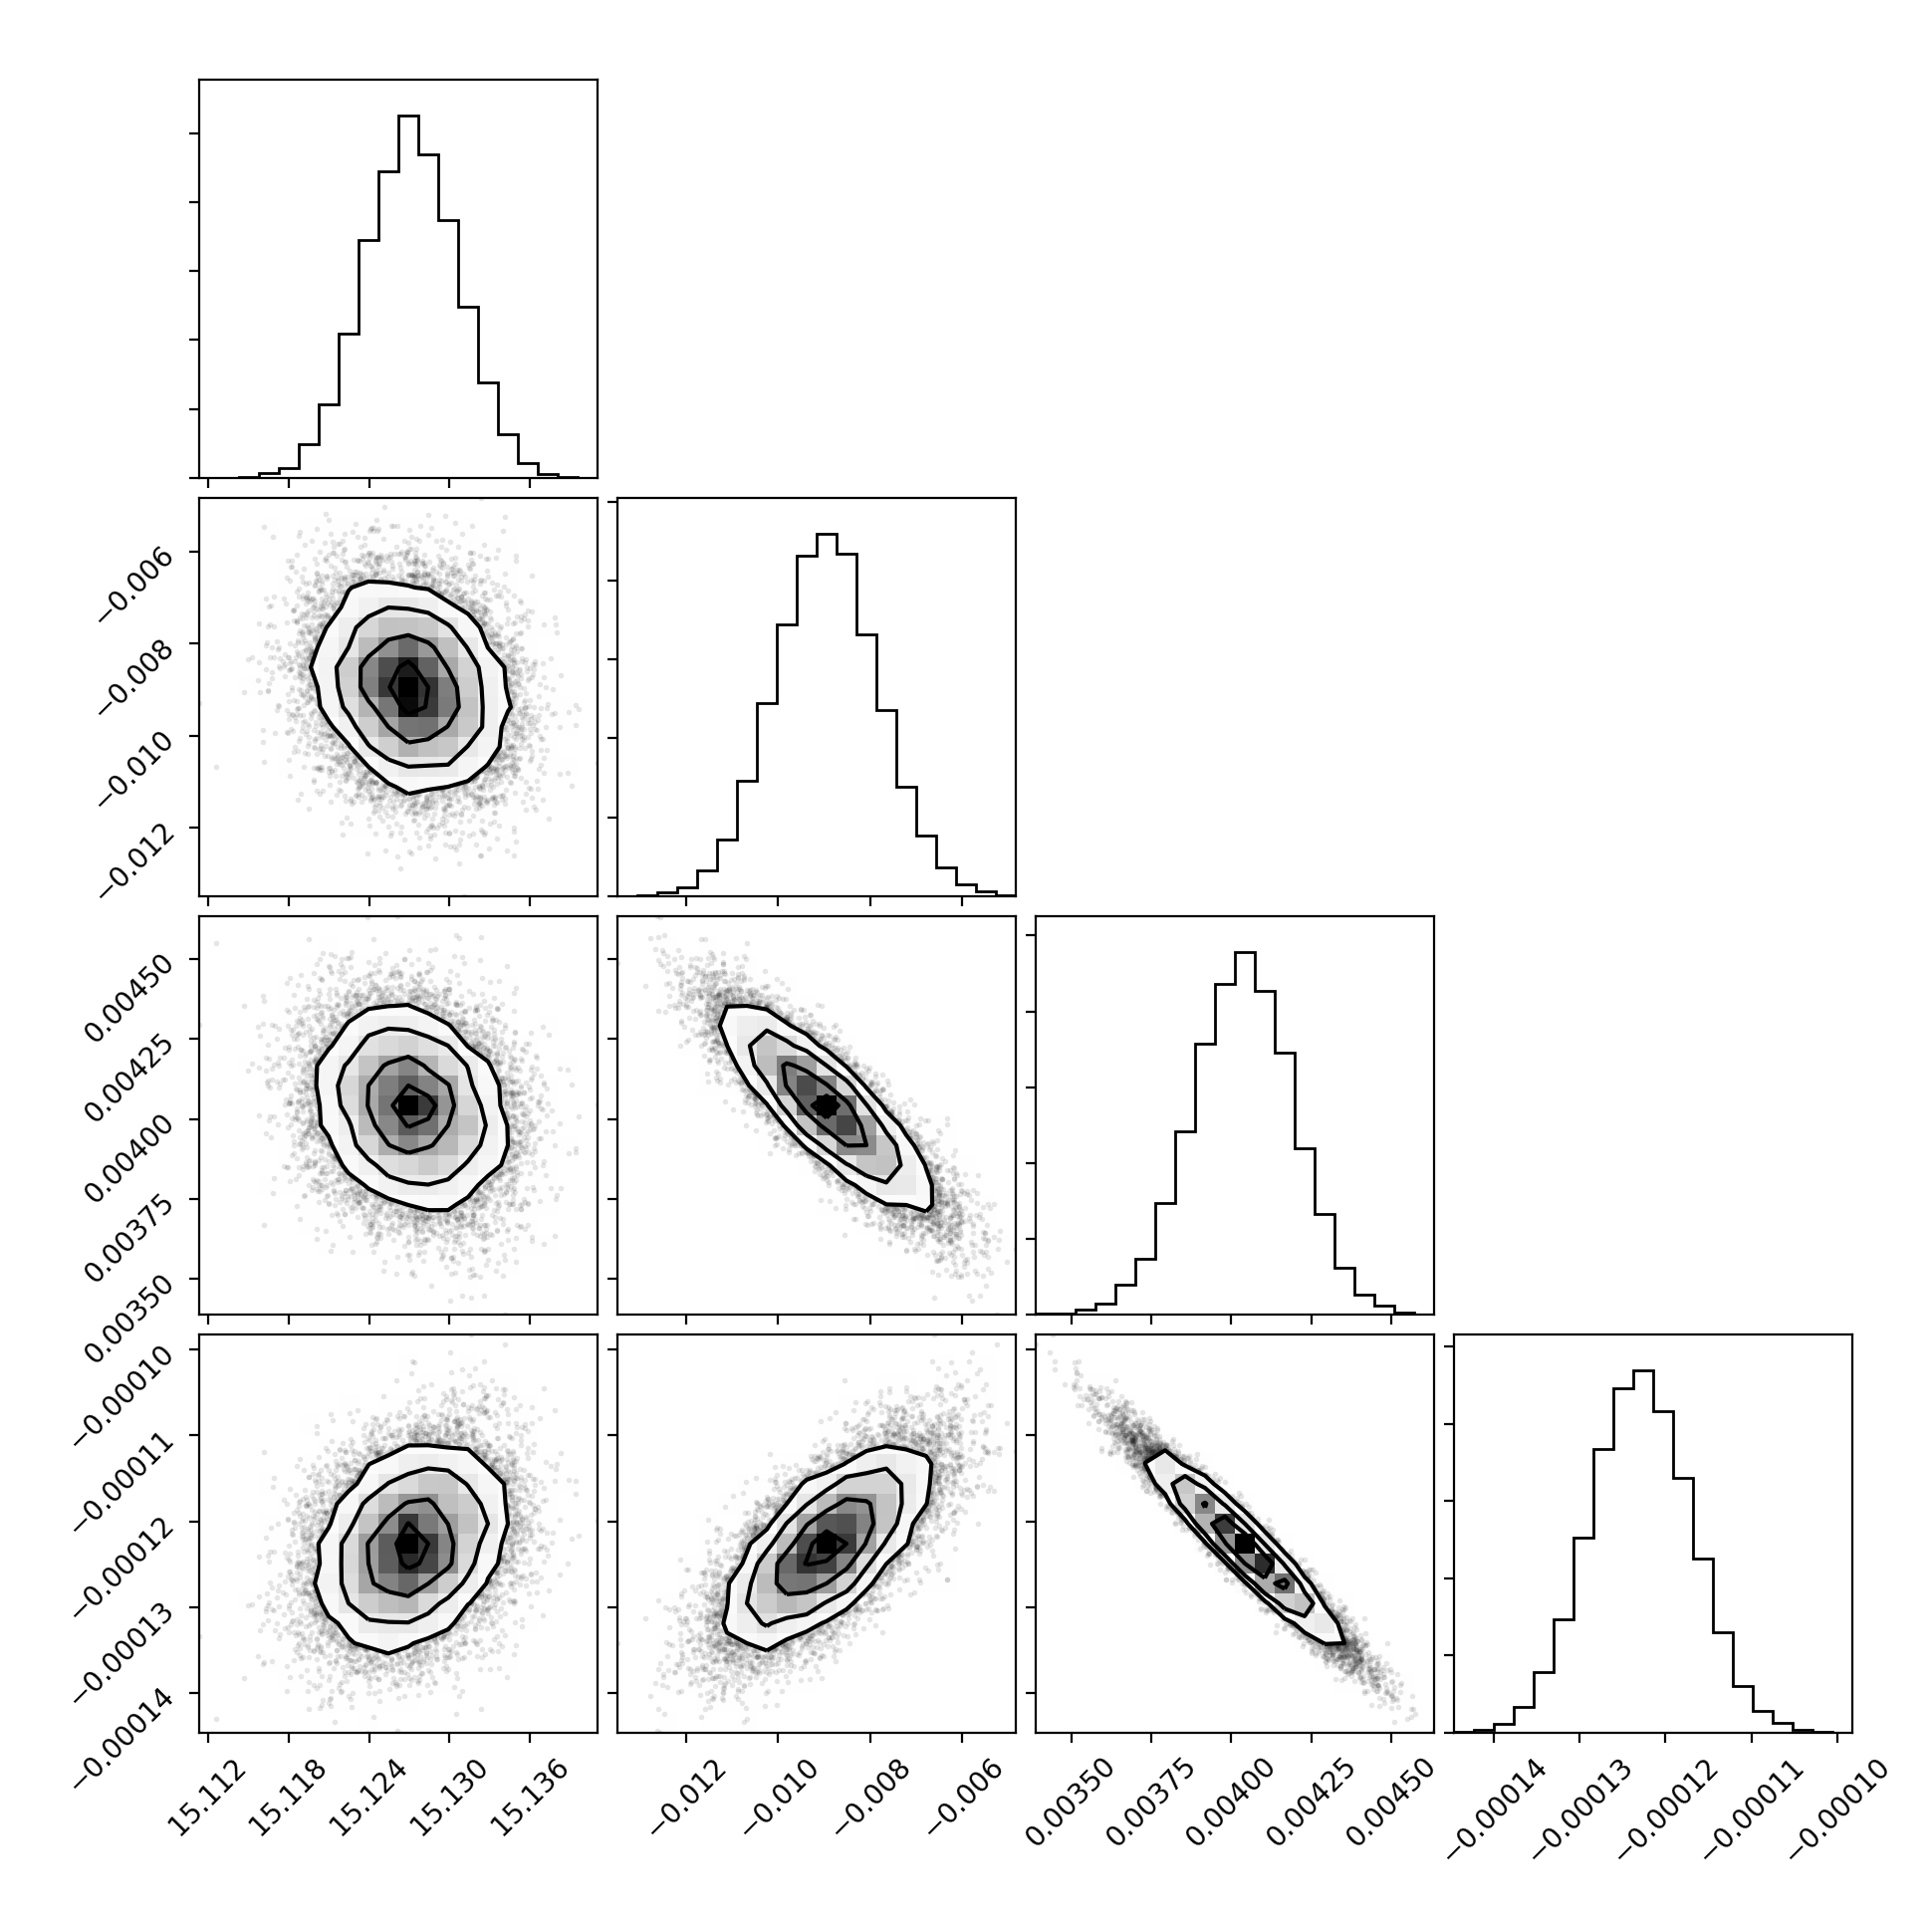

In [25]:
samples = sampler.get_chain(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int))
fig = corner.corner(samples)

<IPython.core.display.Javascript object>


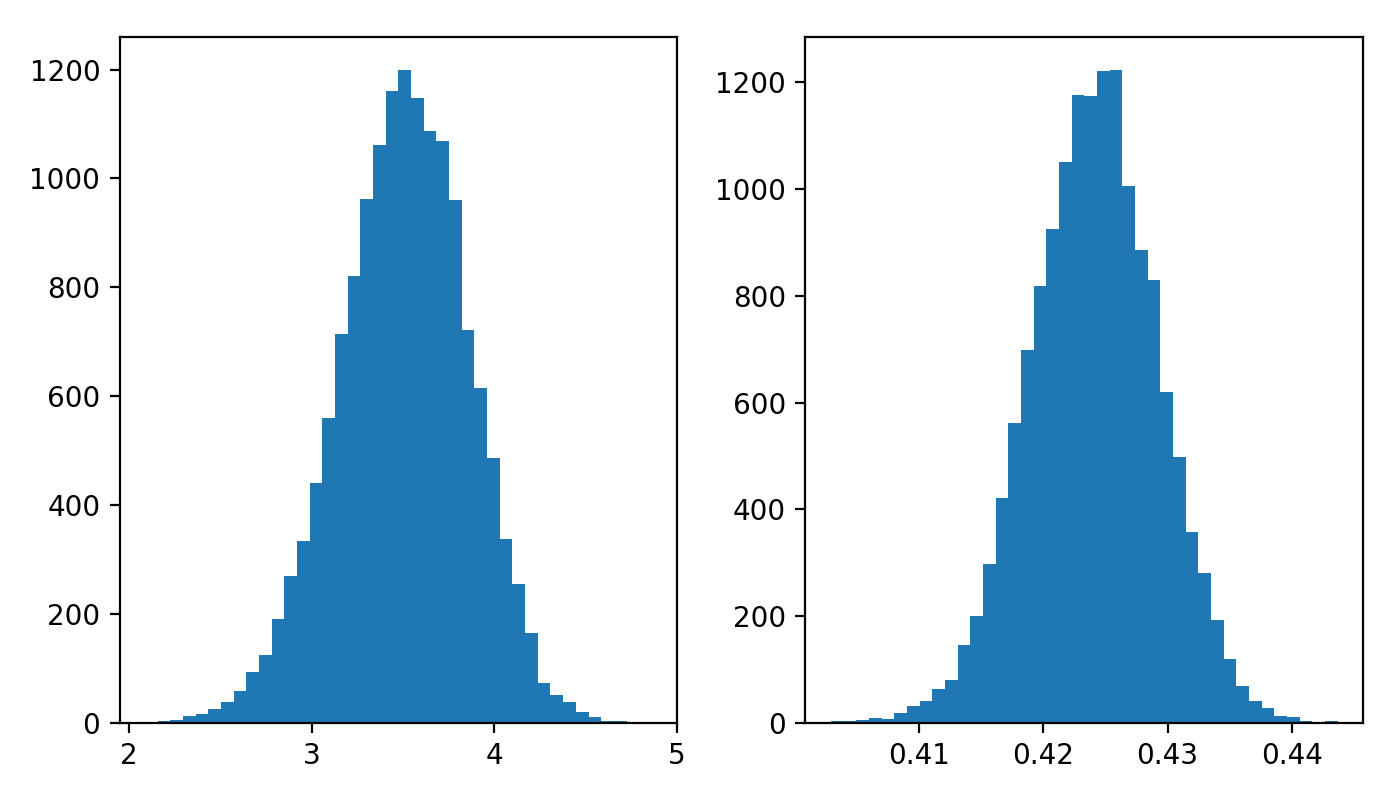

68% CR on t_peak is: [3.15502774 3.51515901 3.85279685]
68% CR on dm_15 is: [0.41895312 0.42418173 0.42920636]


In [26]:
# derivative gives quadratic
# (-b +/- sqrt(b**2 - 4*a*c))/2a

t_peak = (-2*samples[:,2] + np.sqrt(4*samples[:,2]**2 - 4*samples[:,1]*3*samples[:,3]))/(2*samples[:,3])

dm_15 = np.zeros_like(t_peak)
for samp_num, (p, t) in enumerate(zip(samples, t_peak)):
    dm_15[samp_num] = np.polyval(p[::-1], t+15) - np.polyval(p[::-1], t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
ax1.hist(t_peak, bins=40)
ax2.hist(dm_15, bins=40)
fig.tight_layout()

print('68% CR on t_peak is: {}'.format(np.percentile(t_peak, (15.865,50,84.135))))
print('68% CR on dm_15 is: {}'.format(np.percentile(dm_15, (15.865,50,84.135))))

<IPython.core.display.Javascript object>


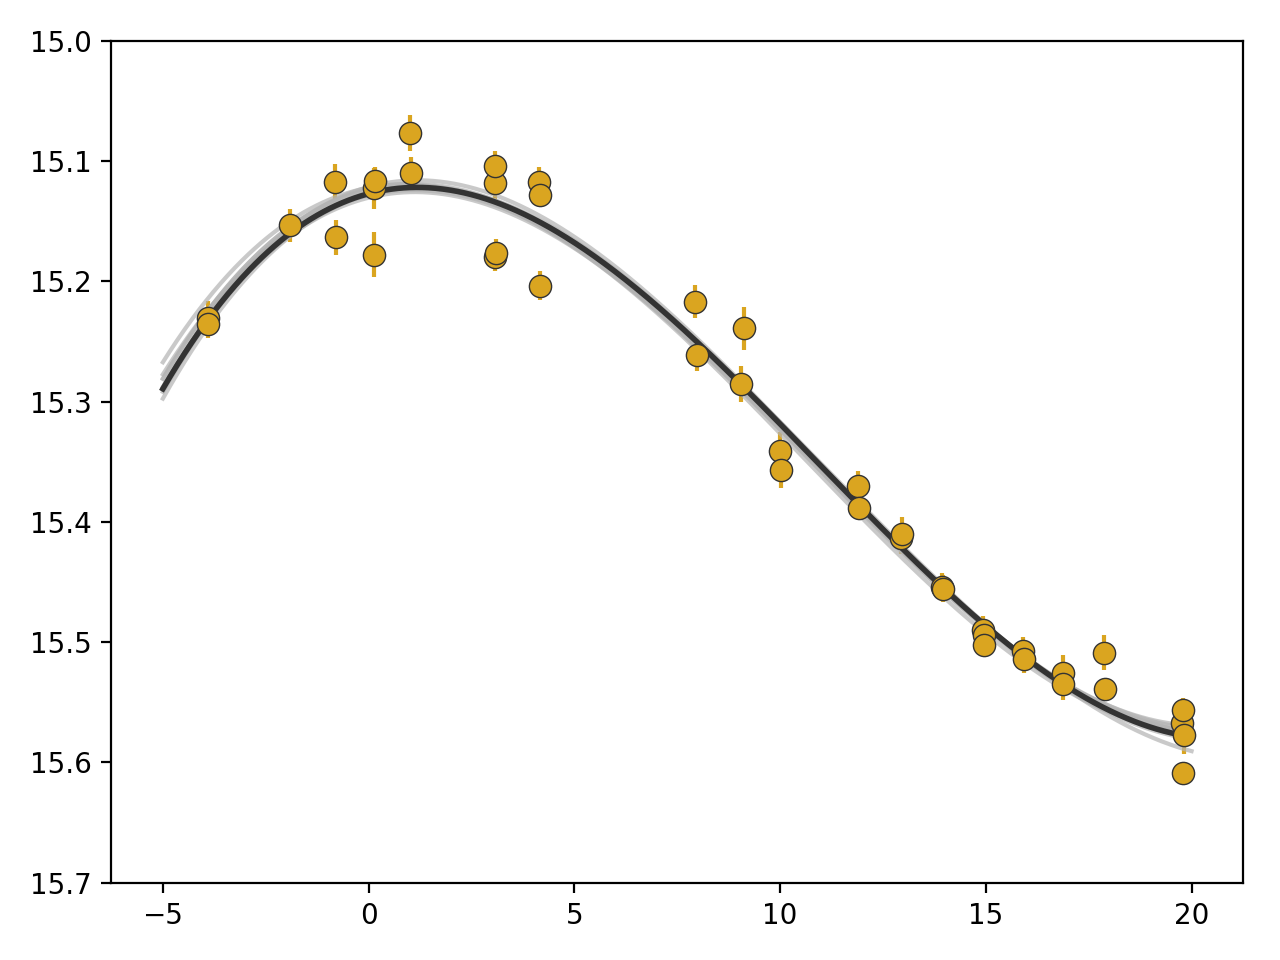

In [27]:
plt.figure()
plt.errorbar(t_rf[i_peak], mags[i_peak], emags[i_peak], 
             fmt='o', color='GoldenRod', 
             mec='0.2', mew=0.5, ms=8)


t_grid = np.linspace(-5, 20,1000)


max_post = samples[np.argmax(sampler.get_log_prob(flat=True,
                            discard=10*np.ceil(np.max(tau)).astype(int),
                            thin=np.ceil(np.max(tau)).astype(int)))]
for samp_num in np.random.choice(len(samples), 10, replace=False):
    plt.plot(t_grid, 
             np.polyval(samples[samp_num,::-1], t_grid),
             '0.7', alpha=0.7)
plt.plot(t_grid, 
         np.polyval(max_post[::-1], t_grid),
         '0.2', lw=2)
    
plt.ylim(15.7,15.)
plt.tight_layout()